# AR-VAE

We consider AR-VAE, a variational autoencoder in which the prior is parameterized by an autoregressive model rather than a standard Gaussian. 

## 1. Setup

In [1]:
#@markdown

!pip -q install datasets pychalk

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
s3fs 2022.3.0 requires fsspec==2022.3.0, but you have fsspec 2023.10.0 which is incompatible.


In [2]:
#@markdown

from dataclasses import dataclass
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.utils import save_image

## 2. Dataset

In [22]:
#@markdown

class CelebAFaces(Dataset):
    """CelebA faces dataset.
    
    Parameters
    ----------
    
    resolution: int - Image resolution.
    
    Example
    -------
    
    >>> dataset = CelebAFaces(resolution=256)
    """
    
    def __init__(self, resolution: int) -> None:
        """Initializes the dataset."""
        
        self.resolution = resolution
        
        # Load the dataset in streaming mode from Hugging Face.
        
        self._dataset = load_dataset(
            path='nielsr/CelebA-faces', 
            split='train', 
            streaming=True,
        ).shuffle()
        
        # Create an iterator for the dataset.
        
        self._dataset_iterator = iter(self._dataset)
        
        # Define a transform to be applied to each example.
        
        self._transform = transforms.Compose([
            transforms.Resize(
                size=(self.resolution, self.resolution),
                interpolation=0,
            ),
            transforms.PILToTensor(),
            transforms.Lambda(lambda x: x / 255.),
        ])
        
        # Get the length of the dataset.
        
        self._length = self._dataset.info.splits['train'].num_examples
        
    def __len__(self) -> int:
        """Returns the length of the dataset."""
        
        return self._length

    def __getitem__(self, index: int) -> torch.Tensor:
        """Returns an example from the dataset."""
        
        example = next(self._dataset_iterator)['image']
        example = self._transform(example)
        
        return example

In [23]:
#@markdown

train_dataset = CelebAFaces(resolution=128)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, num_workers=2)

## 3. Model

In [3]:
#@markdown

@dataclass
class CausalCNNOptions:
    """Causal CNN options."""

    hidden_channels: int
    kernel_size: int
    vocabulary_size: int
    sequence_length: int
    embedding_dimension: int

In [4]:
#@markdown

class CausalCNN(nn.Module):
    """Causal CNN."""
    
    def __init__(self, options: CausalCNNOptions) -> None:
        """Initializes the module."""
        
        super(CausalCNN, self).__init__()
        self.options = options
        
        self.position_embedding = nn.Embedding(num_embeddings=options.sequence_length, embedding_dim=options.embedding_dimension)
        
        self.convolution_1 = nn.Conv1d(in_channels=options.embedding_dimension + options.vocabulary_size, out_channels=options.hidden_channels, kernel_size=options.kernel_size, stride=1, padding=0, dilation=1)
        self.convolution_2 = nn.Conv1d(in_channels=options.hidden_channels, out_channels=options.hidden_channels, kernel_size=options.kernel_size, stride=1, padding=0, dilation=2)
        self.convolution_3 = nn.Conv1d(in_channels=options.hidden_channels, out_channels=options.hidden_channels, kernel_size=options.kernel_size, stride=1, padding=0, dilation=4)
        self.convolution_4 = nn.Conv1d(in_channels=options.hidden_channels, out_channels=options.hidden_channels, kernel_size=options.kernel_size, stride=1, padding=0, dilation=16)
        self.convolution_5 = nn.Conv1d(in_channels=options.hidden_channels, out_channels=options.hidden_channels, kernel_size=options.kernel_size, stride=1, padding=0, dilation=64)
        self.convolution_6 = nn.Conv1d(in_channels=options.hidden_channels, out_channels=options.vocabulary_size, kernel_size=options.kernel_size, stride=1, padding=0, dilation=128)

        self.padding_1 = (self.options.kernel_size, -1)
        self.padding_2 = ((self.options.kernel_size - 1) * 2, 0, 0, 0)
        self.padding_3 = ((self.options.kernel_size - 1) * 4, 0, 0, 0)
        self.padding_4 = ((self.options.kernel_size - 1) * 16, 0, 0, 0)
        self.padding_5 = ((self.options.kernel_size - 1) * 64, 0, 0, 0)
        self.padding_6 = ((self.options.kernel_size - 1) * 128, 0, 0, 0)
        
    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        """Forward pass."""
        
        # Embeddings.
 
        tokens = tokens.to(int).cuda()
        positions = torch.arange(self.options.sequence_length).to(int).cuda()
        positions = positions.view(1, -1).repeat(tokens.size(0), 1)
        
        token_embeddings = F.one_hot(tokens, num_classes=self.options.vocabulary_size)
        position_embeddings = self.position_embedding(positions)
        
        x = torch.cat((token_embeddings, position_embeddings), dim=-1)
        
        # CNN.
        
        x = x.transpose(-2, -1)
        x = F.leaky_relu(self.convolution_1(F.pad(x, self.padding_1)))
        x = F.leaky_relu(self.convolution_2(F.pad(x, self.padding_2))) #+ x
        x = F.leaky_relu(self.convolution_3(F.pad(x, self.padding_3))) #+ x
        x = F.leaky_relu(self.convolution_4(F.pad(x, self.padding_4))) #+ x
        x = F.leaky_relu(self.convolution_5(F.pad(x, self.padding_5))) #+ x
        x = self.convolution_6(F.pad(x, self.padding_6))
        x = x.transpose(-2, -1)
        
        # Logits.
        
        x = F.log_softmax(x, dim=-1)
    
        return x

In [716]:
sum([p.numel() for p in model.parameters()])

27458

In [6]:
#@markdown

from torchvision.datasets import MNIST

mnist_dataset = MNIST(root='.', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.round()),
]))

mnist_dataloader = DataLoader(dataset=mnist_dataset, shuffle=True, batch_size=128)

In [175]:
#@markdown

#model = CausalCNN(CausalCNNOptions(hidden_channels=32, kernel_size=6, sequence_length=28*28, vocabulary_size=2, embedding_dimension=2)).cuda()
#model = torch.load('./causal-cnn-mnist-2.pt')
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [191]:
epochs = 5
model.train()

for epoch in range(epochs):
    for batch_index, (y, _) in enumerate(mnist_dataloader):
        if (len(y) != 128):
            continue
            
        y = y.to(int).cuda().view(128, 28*28)
        yp = model(y)

        optimizer.zero_grad()
        loss = criterion(yp.view(-1, 2), y.flatten())
        loss.backward()
        optimizer.step()
        
        if (batch_index % 100) == 0:
            print(f'epoch {epoch + 1}/{epochs}, batch {batch_index + 1}/{len(mnist_dataset)//128} - {loss.detach().item()}')

epoch 1/5, batch 1/468 - 0.0765201672911644
epoch 1/5, batch 101/468 - 0.07244537025690079
epoch 1/5, batch 201/468 - 0.07532253861427307
epoch 1/5, batch 301/468 - 0.0751049593091011
epoch 1/5, batch 401/468 - 0.07580901682376862
epoch 2/5, batch 1/468 - 0.07420516759157181
epoch 2/5, batch 101/468 - 0.07745398581027985
epoch 2/5, batch 201/468 - 0.0743526816368103
epoch 2/5, batch 301/468 - 0.07411393523216248
epoch 2/5, batch 401/468 - 0.07624170929193497
epoch 3/5, batch 1/468 - 0.0742465928196907
epoch 3/5, batch 101/468 - 0.0736582800745964
epoch 3/5, batch 201/468 - 0.07644883543252945
epoch 3/5, batch 301/468 - 0.07522011548280716
epoch 3/5, batch 401/468 - 0.07101801782846451
epoch 4/5, batch 1/468 - 0.07387808710336685
epoch 4/5, batch 101/468 - 0.07488328218460083
epoch 4/5, batch 201/468 - 0.07749556750059128
epoch 4/5, batch 301/468 - 0.07463105022907257
epoch 4/5, batch 401/468 - 0.07692161202430725
epoch 5/5, batch 1/468 - 0.07289910316467285
epoch 5/5, batch 101/468 - 0

In [155]:
def sample_greedy(model: CausalCNN, batch_size: int, prefix: torch.Tensor = None) -> torch.Tensor:
    """Samples from a CausalCNN."""
    
    model.eval()
    
    sequence_length = model.options.sequence_length
    position = 0
    sample = torch.zeros((batch_size, sequence_length))
    
    if prefix is not None:
        position = prefix.size(0)
        sample[:, : position] = prefix
    
    for i in range(position, sequence_length):
        logits = model(sample)[:, i, 1].detach()
        probabilities = torch.exp(logits)
        values = torch.rand(batch_size).cuda() < probabilities
        
        sample[:, i] = values
    
    sample = sample.view(batch_size, 1, 28, 28)
    
    return sample

In [10]:
def show_prefix(model, prefix):
    
    sequence_length = model.options.sequence_length
    offset = prefix.size(0)

    sample = torch.zeros(sequence_length).cuda()
    sample[: offset] = prefix
    
    return sample

In [11]:
def show_distribution(model, prefix):
    model.eval()
        
    sequence_length = model.options.sequence_length
    offset = 0
    sample = torch.zeros(sequence_length).cuda()
    
    if prefix is not None:
        offset = prefix.size(0)
        sample[: offset] = prefix
    
    logits = model(sample.view(1, sequence_length)).detach()
    probability = torch.exp(logits)[0,:,1]
    
    return probability

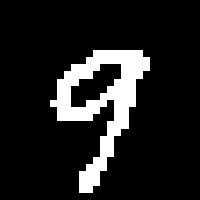

In [196]:
example = mnist_dataset[45][0]

transforms.ToPILImage()(example).resize((200, 200), 0)

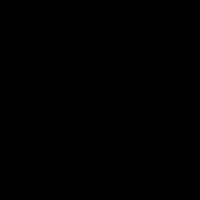

In [200]:
prefix = example.flatten()[: 10]

transforms.ToPILImage()(show_prefix(model, prefix).view(28, 28)).resize((200, 200), 0)

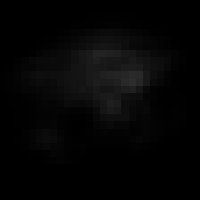

In [201]:
transforms.ToPILImage()(show_distribution(model, prefix).view(28, 28)).resize((200,200),0)

In [397]:
save_image(sample_greedy(model, batch_size=128, prefix=prefix), './completions2.png')

In [68]:
torch.save(model, 'causal-cnn-mnist-3.pt')